In [1]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def graph_spectrogram(wav_file):
    fs, data = wavfile.read(wav_file)
    nfft = 255
    noverlap = 155
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx.T

In [3]:
train_y = np.load("../Data2/TrainingLabels.npy")
files = np.load("../Data2/TrainingFiles.npy")

## File -> Spectrogram

- $x^{\langle n \rangle}$ 은 (Timestep,freq) 의 shape을 갖는 스펙트로그램
- $y^{\langle n \rangle}$ 은 ($T_y$, 1)의 shape을 갖는 label 값
- 여기에서, $T_y$는 Model의 1D Convolution layer의 아웃풋이자, GRU layer의 갯수 = GRU의 출력 갯수 

/home/pmp/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


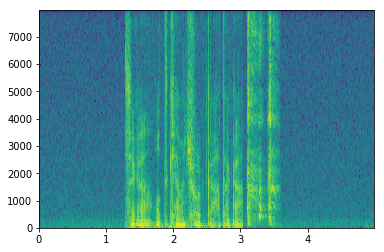

In [4]:
train_x = []

for file in files:
    train_x.append(graph_spectrogram(file))
    
X = np.array(train_x)

In [5]:
Y = train_y.reshape((train_y.shape[0],train_y.shape[1],1))

In [6]:
print("The shape of X_train : " + str(X.shape))
print("The shape of train_Labels : " + str(Y.shape))

The shape of X_train : (500, 798, 128)
The shape of train_Labels : (500, 196, 1)


## Build Model

<img src="../DataSynthesis2/img/Fig2.png" style="width:500px;height:500px;">

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

In [8]:
# GRADED FUNCTION: model

def model(input_shape):    
    X_input = Input(shape = input_shape)
    
    X = Conv1D(98, 15, strides=4)(X_input)                    # CONV1D
    X = BatchNormalization()(X)                                # Batch normalization
    X = Activation('relu')(X)                                  # ReLu activation
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)

    X = GRU(units = 64, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    
    X = GRU(units = 64, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [9]:
Tx = 798 # The number of time steps input to the model from the spectrogram
n_freq = 128 # Number of frequencies input to the model at each time step of the spectrogram

model = model(input_shape = (Tx, n_freq))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 798, 128)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 98)           188258    
_________________________________________________________________
batch_normalization (BatchNo (None, 196, 98)           392       
_________________________________________________________________
activation (Activation)      (None, 196, 98)           0         
_________________________________________________________________
dropout (Dropout)            (None, 196, 98)           0         
_________________________________________________________________
gru (GRU)                    (None, 196, 64)           31296     
_________________________________________________________________
dropout_1 (Dropout)          (None, 196, 64)           0     

In [11]:
opt = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [13]:
history = model.fit(X, Y, batch_size = 32, epochs=1000)

Train on 500 samples
Epoch 1/1000
500/500 [==============================] - 7s 13ms/sample - loss: 1.1632 - acc: 0.4883
Epoch 2/1000
500/500 [==============================] - 5s 9ms/sample - loss: 1.1586 - acc: 0.4889
Epoch 3/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.1439 - acc: 0.4908
Epoch 4/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.1572 - acc: 0.4906
Epoch 5/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.1582 - acc: 0.4893
Epoch 6/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.1615 - acc: 0.4870
Epoch 7/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.1582 - acc: 0.4934
Epoch 8/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.1547 - acc: 0.4920
Epoch 9/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.1588 - acc: 0.4896
Epoch 10/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.1601 -

500/500 [==============================] - 4s 9ms/sample - loss: 1.0918 - acc: 0.4926
Epoch 83/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0981 - acc: 0.4987
Epoch 84/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0880 - acc: 0.4977
Epoch 85/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0938 - acc: 0.4971
Epoch 86/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0859 - acc: 0.4993
Epoch 87/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0757 - acc: 0.5022
Epoch 88/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0873 - acc: 0.4926
Epoch 89/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0947 - acc: 0.4935
Epoch 90/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0920 - acc: 0.4986
Epoch 91/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0909 - acc: 0.4967
Epoch 92/1000


500/500 [==============================] - 4s 9ms/sample - loss: 1.0343 - acc: 0.5118
Epoch 164/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0409 - acc: 0.5122
Epoch 165/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0298 - acc: 0.5108
Epoch 166/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0359 - acc: 0.5104
Epoch 167/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0444 - acc: 0.5108
Epoch 168/1000
500/500 [==============================] - 5s 9ms/sample - loss: 1.0303 - acc: 0.5105
Epoch 169/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0384 - acc: 0.5116
Epoch 170/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0338 - acc: 0.5102
Epoch 171/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0430 - acc: 0.5116
Epoch 172/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0321 - acc: 0.5120
Epoch

500/500 [==============================] - 4s 9ms/sample - loss: 1.0062 - acc: 0.5328
Epoch 245/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0108 - acc: 0.5311
Epoch 246/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0120 - acc: 0.5313
Epoch 247/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9968 - acc: 0.5359
Epoch 248/1000
500/500 [==============================] - 4s 9ms/sample - loss: 1.0052 - acc: 0.5339
Epoch 249/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9971 - acc: 0.5374
Epoch 250/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9956 - acc: 0.5346
Epoch 251/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9968 - acc: 0.5385
Epoch 252/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9984 - acc: 0.5346
Epoch 253/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9958 - acc: 0.5389
Epoch

500/500 [==============================] - 4s 9ms/sample - loss: 0.9843 - acc: 0.5572
Epoch 326/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9716 - acc: 0.5647
Epoch 327/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9683 - acc: 0.5642
Epoch 328/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9897 - acc: 0.5564
Epoch 329/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9788 - acc: 0.5629
Epoch 330/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9787 - acc: 0.5647
Epoch 331/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9646 - acc: 0.5633
Epoch 332/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9751 - acc: 0.5612
Epoch 333/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9770 - acc: 0.5594
Epoch 334/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9761 - acc: 0.5641
Epoch

500/500 [==============================] - 4s 9ms/sample - loss: 0.9655 - acc: 0.5801
Epoch 407/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9567 - acc: 0.5887
Epoch 408/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9512 - acc: 0.5892
Epoch 409/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9642 - acc: 0.5940
Epoch 410/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9614 - acc: 0.5910
Epoch 411/1000
500/500 [==============================] - 5s 9ms/sample - loss: 0.9538 - acc: 0.5921
Epoch 412/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9606 - acc: 0.5938
Epoch 413/1000
500/500 [==============================] - 5s 9ms/sample - loss: 0.9609 - acc: 0.5845
Epoch 414/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9554 - acc: 0.5893
Epoch 415/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9616 - acc: 0.5843
Epoch

500/500 [==============================] - 4s 9ms/sample - loss: 0.9511 - acc: 0.6136
Epoch 488/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9488 - acc: 0.6119
Epoch 489/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9513 - acc: 0.6266
Epoch 490/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9454 - acc: 0.6209
Epoch 491/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9423 - acc: 0.6209
Epoch 492/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9405 - acc: 0.6177
Epoch 493/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9393 - acc: 0.6199
Epoch 494/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9344 - acc: 0.6182
Epoch 495/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9377 - acc: 0.6153
Epoch 496/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9400 - acc: 0.6097
Epoch

500/500 [==============================] - 4s 9ms/sample - loss: 0.9361 - acc: 0.6453
Epoch 569/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9240 - acc: 0.6477
Epoch 570/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9340 - acc: 0.6482
Epoch 571/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9351 - acc: 0.6492
Epoch 572/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9214 - acc: 0.6420
Epoch 573/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9337 - acc: 0.6477
Epoch 574/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9326 - acc: 0.6498
Epoch 575/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9201 - acc: 0.6537
Epoch 576/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9335 - acc: 0.6477
Epoch 577/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9320 - acc: 0.6483
Epoch

500/500 [==============================] - 4s 9ms/sample - loss: 0.9210 - acc: 0.6776
Epoch 650/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9224 - acc: 0.6707
Epoch 651/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9197 - acc: 0.6769
Epoch 652/1000
500/500 [==============================] - 5s 9ms/sample - loss: 0.9254 - acc: 0.6758
Epoch 653/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9134 - acc: 0.6823
Epoch 654/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9235 - acc: 0.6848
Epoch 655/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9120 - acc: 0.6809
Epoch 656/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9189 - acc: 0.6729
Epoch 657/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9143 - acc: 0.6747
Epoch 658/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9133 - acc: 0.6840
Epoch

500/500 [==============================] - 4s 9ms/sample - loss: 0.9053 - acc: 0.7051
Epoch 731/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9050 - acc: 0.7075
Epoch 732/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9059 - acc: 0.7147
Epoch 733/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9065 - acc: 0.7034
Epoch 734/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9140 - acc: 0.7179
Epoch 735/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8956 - acc: 0.7169
Epoch 736/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9153 - acc: 0.7089
Epoch 737/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9148 - acc: 0.7062
Epoch 738/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9081 - acc: 0.7055
Epoch 739/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9056 - acc: 0.7171
Epoch

500/500 [==============================] - 4s 9ms/sample - loss: 0.8867 - acc: 0.7427
Epoch 812/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8855 - acc: 0.7363
Epoch 813/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9024 - acc: 0.7357
Epoch 814/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8996 - acc: 0.7291
Epoch 815/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8913 - acc: 0.7339
Epoch 816/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8994 - acc: 0.7301
Epoch 817/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8915 - acc: 0.7382
Epoch 818/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8933 - acc: 0.7407
Epoch 819/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8988 - acc: 0.7393
Epoch 820/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.9049 - acc: 0.7392
Epoch

500/500 [==============================] - 4s 9ms/sample - loss: 0.8924 - acc: 0.7494
Epoch 893/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8857 - acc: 0.7516
Epoch 894/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8898 - acc: 0.7518
Epoch 895/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8910 - acc: 0.7540
Epoch 896/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8893 - acc: 0.7588
Epoch 897/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8912 - acc: 0.7604
Epoch 898/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8936 - acc: 0.7559
Epoch 899/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8870 - acc: 0.7601
Epoch 900/1000
500/500 [==============================] - 5s 9ms/sample - loss: 0.8837 - acc: 0.7577
Epoch 901/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8898 - acc: 0.7654
Epoch

500/500 [==============================] - 5s 9ms/sample - loss: 0.8722 - acc: 0.7731
Epoch 974/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8758 - acc: 0.7773
Epoch 975/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8919 - acc: 0.7726
Epoch 976/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8806 - acc: 0.7732
Epoch 977/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8864 - acc: 0.7823
Epoch 978/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8714 - acc: 0.7819
Epoch 979/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8739 - acc: 0.7862
Epoch 980/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8773 - acc: 0.7844
Epoch 981/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8825 - acc: 0.7797
Epoch 982/1000
500/500 [==============================] - 4s 9ms/sample - loss: 0.8722 - acc: 0.7809
Epoch

In [14]:
model.save('my_model.h5')

#### [Load test data]

In [28]:
test_y = np.load("../Data2/TestLabels.npy")
testfiles = np.load("../Data2/TestFiles.npy")

/home/pmp/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


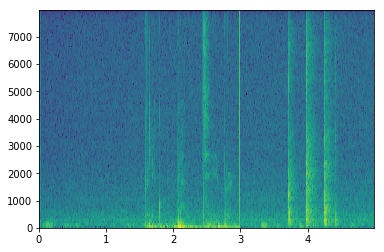

In [16]:
test_x = []

for file in testfiles:
    test_x.append(graph_spectrogram(file))
    
X_test = np.array(test_x)

In [18]:
Y_test = test_y.reshape((test_y.shape[0],test_y.shape[1],1))

In [20]:
print("The shape of X_test : " + str(X_test.shape))
print("The shape of test_Labels : " + str(Y_test.shape))

The shape of X_test : (100, 798, 128)
The shape of test_Labels : (100, 196, 1)


In [21]:
loss, acc = model.evaluate(X_test, Y_test)
print("Dev set accuracy = ", acc)

100/100 [==============================] - 0s 4ms/sample - loss: 0.7567 - acc: 0.8572
Dev set accuracy =  0.8571939


In [22]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    nfft = 256 # Length of each window segment
    fs = 8000 # Sampling frequencies
    fs = rate # Sampling frequencies
    #noverlap = 120 # Overlap between windows
    noverlap = 0
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

def detect_triggerword(filename, x):
    plt.subplot(2, 1, 1)

    spec = graph_spectrogram(filename)
    x = np.expand_dims(x, axis=0)
    print(x.shape)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

(1, 798, 128)


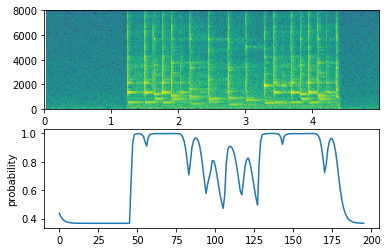

In [33]:
testidx = 30
predictions = detect_triggerword(testfiles[testidx],X_test[testidx])
IPython.display.Audio(testfiles[testidx])